Bayesian Optimisation Workgroup - 29th October 2024 - by Tiago Cumetti and Victor Nonea

# Demo TuRBO: Scalable Global Optimization via Local Bayesian Optimization
Today we are going to be experimenting with the popular TuRBO algorithm, which involves using an adaptive _trust region_ to control the accuracy of our BO model!

### Preliminaries:
#### Imports:

In [1]:
from matplotlib import pyplot as plt, cm
import numpy as np
import sklearn.gaussian_process

#### Target function

Definition of a target function with adjustable oscillatory and quadratic components.

In [2]:
def target_function_builder(d, mean_period=0.1, period_uniform_max_deviation=0.02, osc_weight_ratio=1):
    osc_weight = osc_weight_ratio / (osc_weight_ratio + 1)
    quad_weight = 1 - osc_weight
    periods = mean_period + period_uniform_max_deviation * (2 * np.random.rand(d) - 1)
    def target_function(_input):
        return np.sum(np.sin(_input / periods) ** 2 * osc_weight + _input ** 2 * quad_weight, axis=-1) / (2 * d)

    return target_function



target_function_dim_bounds = [-1, 1]
target_function_dim_origin = 0
target_function_dim_radius = 1

def flat_mesh(d, sections=100, keep_original=False):
    singleton = np.linspace(*target_function_dim_bounds, sections)
    square_mesh = np.meshgrid(*[singleton for _ in range(d)])

    flat_mesh = np.array([D.reshape(-1) for D in square_mesh]).T

    return flat_mesh if not keep_original else (flat_mesh, square_mesh)

def mesh_reshape(V, d, sections=100):
    return V.reshape([sections for _ in range(d)])

def random_sample(d, num, origin=target_function_dim_origin, radius=target_function_dim_radius):
    return np.random.rand(num, d) * 2 * radius + origin - radius

_1d_target_function = target_function_builder(1, osc_weight_ratio=0.1)
_2d_target_function = target_function_builder(2, osc_weight_ratio=0.1)

#### Plot some of the target functions

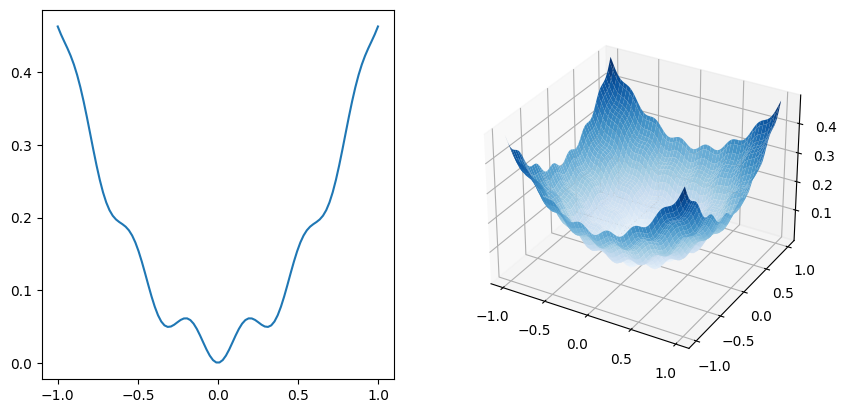

In [3]:
fig = plt.figure(figsize=[10, 4.8])
ax = fig.add_subplot(1, 2, 1)
ax.plot((x := flat_mesh(1)), [_1d_target_function(xi.reshape(-1, 1)) for xi in x])

XY_input, (X, Y) = flat_mesh(2, keep_original=True)
Z_output = _2d_target_function(XY_input)
Z = mesh_reshape(Z_output, 2)

# Plot the surface
ax = fig.add_subplot(1, 2, 2, projection = "3d")
ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap=cm.Blues)

plt.show()

#### Experimental parameters

Run each solver multiple times on a specified problem, collecting mean, standard deviation and best result, and visualizing the performance of each solver over time, to compare the efficiency of different BO algorithms on the same multidimensional problem.

In [13]:
problem_dimension = 2
doe_sample_budget = 5
iter_eval_budget = 100
n_trials = 5

def experiment(*solvers, d=problem_dimension, verbose=0, problem_params={}):
    results = []
    for trial in range(n_trials):
        trial_result = []
        problem = target_function_builder(d, **problem_params)
        for solver in solvers:
            solver_instance = solver(problem, d, doe_sample_budget)
            solver_instance.run(iter_eval_budget)
            trial_result.append(solver_instance.best_y)
        results.append(trial_result)

    # dimensions: trial, solver, timeseries
    timeseries = np.arange(doe_sample_budget + iter_eval_budget)
    results = np.array(results)
    result_means = np.mean(results, axis=0)
    result_stds = np.std(results, axis=0)
    result_best = np.min(results, axis=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    handles = []
    for i, (solver, solver_result, solver_result_std, solver_result_best) in enumerate(zip(solvers, result_means, result_stds, result_best)):
        handles.append(ax.semilogy(timeseries, solver_result, label=solver.__name__, color=f'C{i}')[0])
        bottom_line = np.maximum(solver_result - solver_result_std, solver_result_best)
        ax.fill_between(timeseries, solver_result + solver_result_std, bottom_line, color=f'C{i}', alpha=0.2)

    ax.set_title("Performance Comparison of Optimization Solvers", fontsize=14)
    ax.set_xlabel("Iterations", fontsize=12)
    ax.set_ylabel("Objective Value", fontsize=12)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.legend(handles=handles, loc="upper right")

    plt.tight_layout()
    plt.show()

### Global Bayesian Optimization

Global BO uses a Gaussian Process model to guide the sampling. It selects new points based on Thompson sampling, balancing exploration and exploitation.

In [14]:
class RandomSampler:
    def __init__(self, problem, d, doe_sample_budget, is_reset=False):
        self.problem = problem
        self.d = d
        self.obs_x = []
        self.obs_y = []
        if not is_reset:
            self.best_y = []
        doe = random_sample(d, doe_sample_budget)
        for sample in doe:
            self.evaluate(sample)

    def evaluate(self, sample):
        self.obs_x.append(sample)
        self.obs_y.append(self.problem(sample))
        if self.best_y:
            self.best_y.append(min(self.best_y[-1], self.obs_y[-1]))
        else:
            self.best_y.append(self.obs_y[-1])

    def run(self, budget):
        for _ in range(budget):
            self.evaluate(random_sample(self.d, 1)[0])


class GlobalBO(RandomSampler):
    def __init__(self, problem, d, doe_sample_budget, **kwargs):
        super().__init__(problem, d, doe_sample_budget, **kwargs)

        # kernel = sklearn.gaussian_process.kernels.Matern()
        kernel = None
        self.gp = sklearn.gaussian_process.GaussianProcessRegressor(kernel=kernel)
        self.proxy_sample_size = 100

    def run(self, budget):
        for _ in range(budget):
            # fit GP model
            self.gp.fit(self.obs_x, self.obs_y)

            # Thompson sample
            proxy_sample_x = random_sample(self.d, self.proxy_sample_size)
            proxy_sample_y = self.gp.sample_y(proxy_sample_x).reshape(-1)
            best_proxy_x = proxy_sample_x[min(range(self.proxy_sample_size), key=lambda i: proxy_sample_y[i])]

            self.evaluate(best_proxy_x)

### Baseline Experiment


Comparison of the performance of Random Sampler and Global BO on a 2-dimensional target function.

Since Global BO leverages the GP model to make more informed sampling choices, we expect it to find better (lower) values more quickly than Random Sampler.

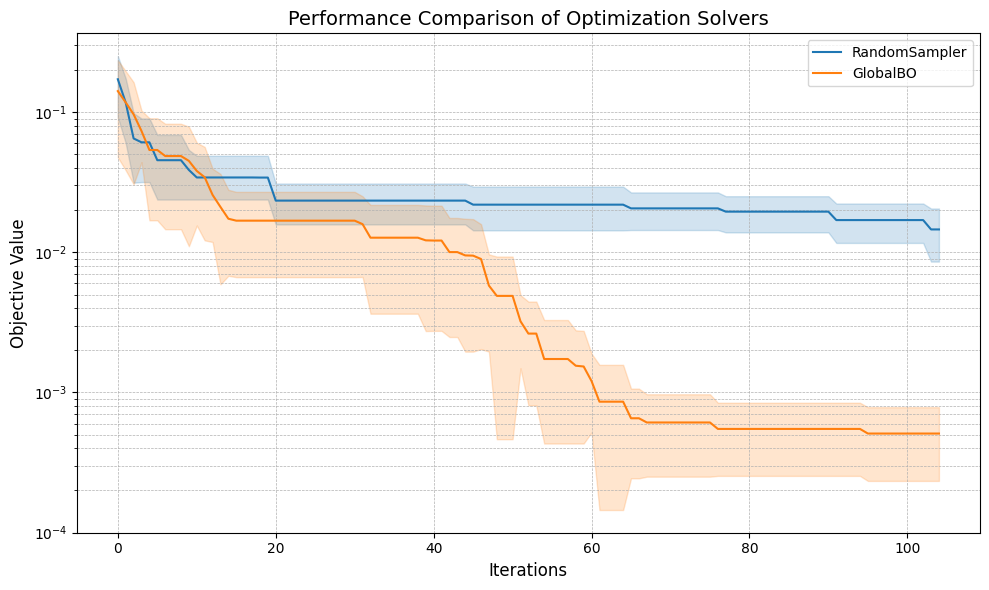

In [15]:
experiment(RandomSampler, GlobalBO, problem_params={'osc_weight_ratio': 0.1}, d=2)

## Exercise: Bayesian Optimization with an adaptive Trust Region

TuRBO (Trust-Region Bayesian Optimization) adapts the trust region (TR) based on the success or failure of recent steps. It does this by expanding the TR when successful and shrinking it when unsuccessful, allowing it to zoom in on promising regions or expand when it needs to explore more broadly.

In [16]:
class TuRBO(GlobalBO):
    def __init__(self, problem, d, doe_sample_budget, **kwargs):
        super().__init__(problem, d, doe_sample_budget, **kwargs)

        self.doe_sample_budget = doe_sample_budget

        self.min_tr_rad = 0.01
        self.max_tr_rad = 1
        self.tr_succ_thresh = 5
        self.tr_fail_thresh = 5

        self.tr_rad = 0.25
        self.tr_succ_count = 0
        self.tr_fail_count = 0

    def run(self, budget):
        while budget > 0:
            # TODO 1: get the best current observation in the input domain, for centering the TR.
            # Tip: use self.obs_x and self.obs_y, assume minimization objective
            best_x = self.obs_x[min(range(len(self.obs_y)), key=lambda i: self.obs_y[i])]

            # TODO 2: make a list of the observations within the hypersquare centered in
            #         best_x with length 2 * self.tr_rad (TR), to locally fit the GP model.
            # Tip: you may use np.max, np.abs
            tr_obs = [(obs_x, obs_y) for obs_x, obs_y in zip(self.obs_x, self.obs_y) if np.max(np.abs(obs_x - best_x)) <= self.tr_rad]

            # Fit the GP to the trust region observations
            self.gp.fit(*zip(*tr_obs))

            # TODO 3: generate a random sample within the hypersquare centered in best_x with length 2 * self.tr_rad (TR) for Thompson Sampling.
            # Tip: use random_sample(self.d, self.proxy_sample_size, origin=..., radius=...)
            proxy_sample_x = random_sample(self.d, self.proxy_sample_size, origin=best_x, radius=self.tr_rad)

            # Thompson sampling
            proxy_sample_y = self.gp.sample_y(proxy_sample_x).reshape(-1)
            best_proxy_x = proxy_sample_x[min(range(self.proxy_sample_size), key=lambda i: proxy_sample_y[i])]

            self.evaluate(best_proxy_x)
            budget -= 1
            improvement = self.best_y[-1] > self.best_y[-2]

            # Update success/failure counters
            # In the original paper, they count *consecutive* successes and failures, here however, since the experiment has
            # relatively few evaluations, we have decided to count all occurences and reset the counters only when changing the TR
            if improvement:
                self.tr_succ_count += 1
            else:
                self.tr_fail_count += 1

            # TODO 4:
            # Adjust the TR radius based on success and failure counts, with resetting if it gets too small.
            # - if the number of successes has reached the success threshold, double the TR radius, up to its maximal value
            # - if the number of failures has reached its theashold, half the TR radius
            # - if the radius becomes lower than the minimal value, reset the entire model:
            #    - You may reuse the __init__ function, with the is_reset keyword
            #    - Truncate the doe budget if it exceeds the run budget
            #    - Be sure to also subtract the doe sample budget from the run budget
            # - if the TR radius has been updated, reset both counters
            if self.tr_succ_count >= self.tr_succ_thresh:
                self.tr_rad = max(2 * self.tr_rad, self.max_tr_rad)
            elif self.tr_fail_count >= self.tr_fail_thresh:
                self.tr_rad /= 2
                if self.tr_rad < self.min_tr_rad:
                    doe_budget = min(self.doe_sample_budget, budget)
                    self.__init__(self.problem, self.d, doe_budget, is_reset=True)
                    budget -= doe_budget

            if self.tr_succ_count >= self.tr_succ_thresh or self.tr_fail_count >= self.tr_fail_thresh:
                self.tr_succ_count, self.tr_fail_count = 0, 0

### Experiment: Comparing Trust Region BO with Global BO

Comparison of the performance of Global BO and TuRBO on a 2-dimensional target function.

TuRBO should reach a better function values than Global BO, demonstrating that local search adjustments (trust region adaptations) provide an advantage.

Global BO may converge to less oprimal solutions, since it's not able to effectively explore and focus on high-potential regions compared to tge adaptive strategy adopted by TuRBO.

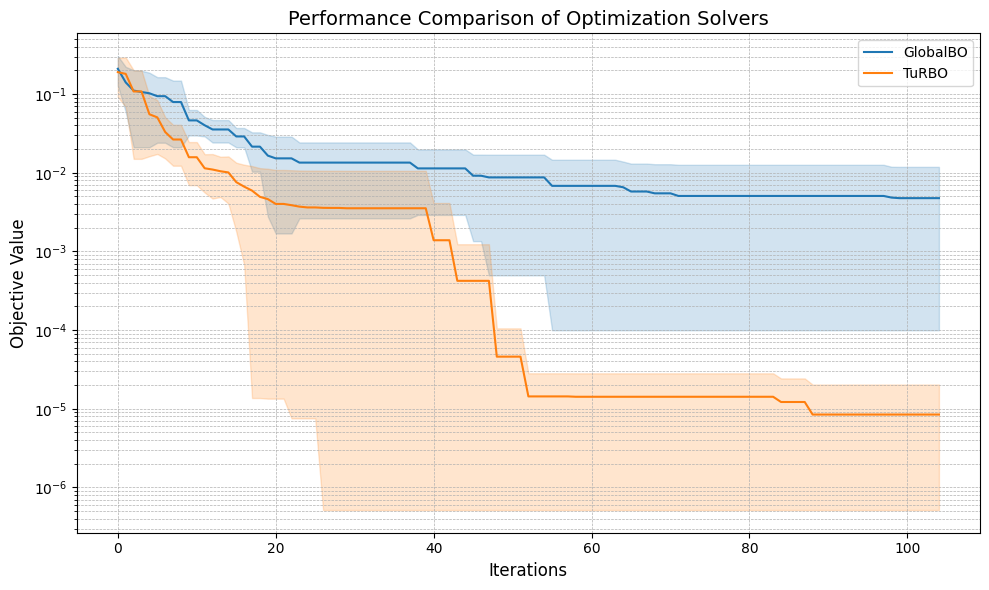

In [17]:
experiment(GlobalBO, TuRBO, problem_params={'osc_weight_ratio': 0.1}, d=2)